In [3]:
# Modules import
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [4]:
# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "Combined Data.csv"))

100%|██████████| 11.1M/11.1M [00:00<00:00, 46.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [5]:
# Quick view of the first 5 rows of data
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
# eliminate rows that don't have text to work with
df = df.loc[df.statement.isna() == False]

In [7]:
# Function to plot the Histogram of the classes
def print_class_histogram(df, text="", ax=None):
    class_totals = pd.concat([df.status.value_counts(), df.status.value_counts(normalize=True)], axis = 1)
    class_totals.columns = ["total", "percentage"]
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (10,5))
    class_totals.total.plot(kind = "bar", title = text + " Histogram ", ax=ax)
    ax.set_xticklabels(class_totals.index, rotation = 0)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    for p in np.arange(len(class_totals.percentage.values)):
        ax.annotate(str(round(class_totals.percentage.values[p]*100,1)) + "%", (p, 100) , ha = 'center', color = "white")
        ax.annotate(f"{class_totals.total.values[p]:,}", (p, 1000) , ha = 'center', color = "Black")
    return ax

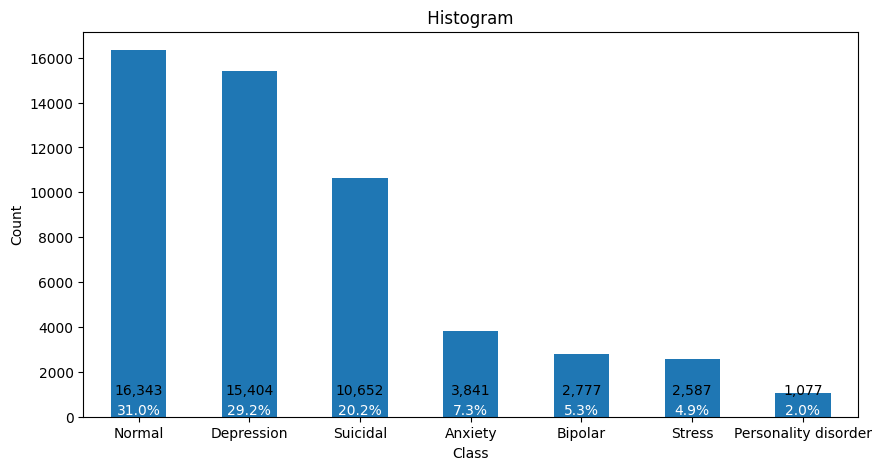

In [8]:
print_class_histogram(df)
plt.show()

In [9]:
# grouping the smaller clases
df_grouped = df.copy()
df_grouped.loc[df.status == 'Normal','status'] = 'normal'
df_grouped.loc[df.status == 'Depression','status'] = 'depression'
df_grouped.loc[(df.status == 'Suicidal') ,'status'] = 'suicidal'
df_grouped.loc[(df.status == 'Anxiety') | (df.status == 'Stress'),'status'] = 'other'
df_grouped.loc[(df.status == 'Bipolar') |(df.status == 'Personality disorder') ,'status'] = 'other'

df_grouped['status_factorized'] = df_grouped.status.factorize()[0]
label_dictionary = df_grouped.status.factorize()[1]

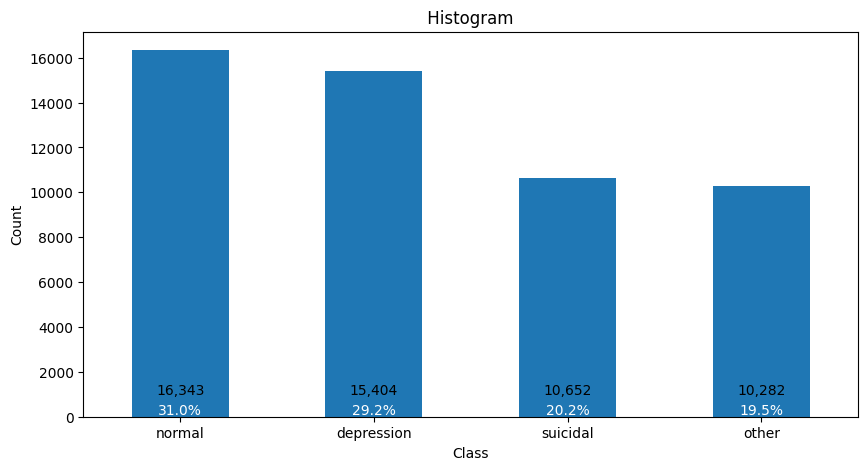

In [10]:
print_class_histogram(df_grouped)
plt.show()

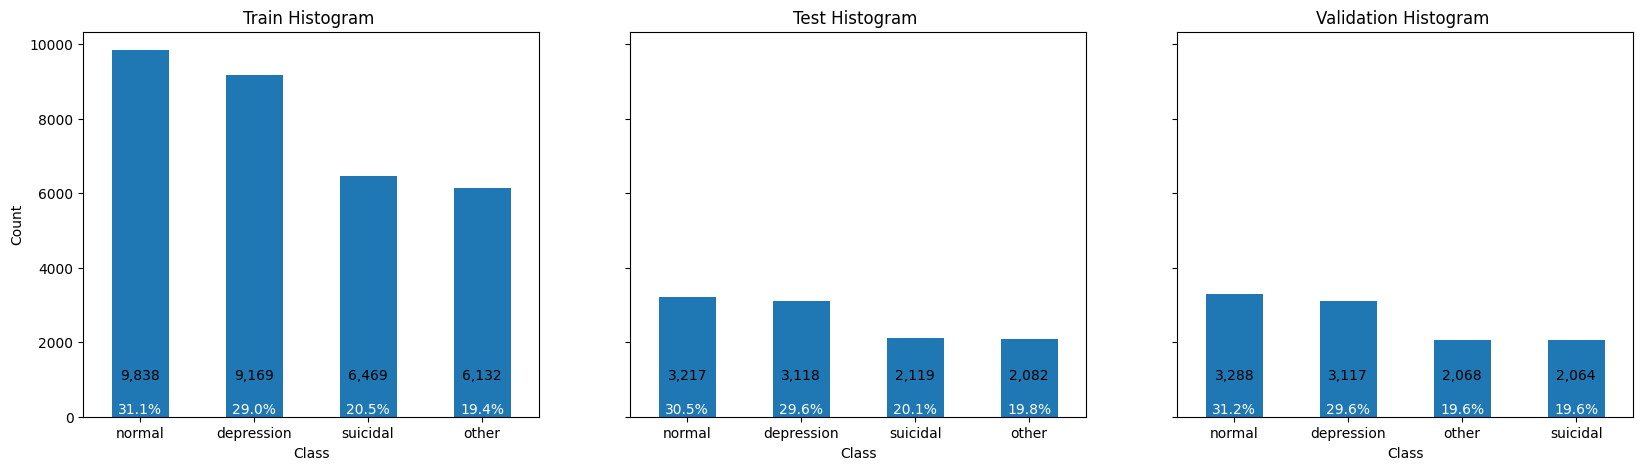

In [11]:
# Split data set into train, test, and validation

train_df, test_df = train_test_split(df_grouped, test_size=0.4, random_state=50)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=50)

# Train data analysis
fig, ax = plt.subplots(1,3, figsize = (20,5), sharey =  True)
print_class_histogram(train_df, "Train", ax = ax[0])
print_class_histogram(test_df, "Test", ax = ax[1])
print_class_histogram(val_df, "Validation", ax = ax[2])
plt.show()


In [12]:
# Length of the statements measured in Number of tokens
train_df.statement.str.split().apply(lambda x: len(x)).describe(percentiles = [0.25, 0.5, 0.75, .85, 0.9, .95, 0.99])

,statement
count,31608.000000
mean,112.119558
std,158.674468
min,1.000000
25%,15.000000
50%,62.000000
75%,148.000000
85%,218.000000
90%,275.000000
95%,389.650000


In [13]:
# Data Processing and Vectorization
# Define variables
max_len = 390 # 726 for 99% of the statements, 390 for 95%
vocab_size = 1000

# Seting variables for training X and y
train_data = train_df.statement.values
train_labels = train_df.status.values

text_vecorization = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                                      output_sequence_length = max_len,
                                                      output_mode= "int",
                                                      pad_to_max_tokens = True,
                                                      standardize = "lower_and_strip_punctuation"
                                                      )
text_vecorization.adapt(train_data)
vocabulary = text_vecorization.get_vocabulary()

In [14]:
print(f"Train data Shape  : {train_data.shape}")
print(f"Vocabulary size   : {text_vecorization.vocabulary_size()}")
print(f"Vocabulary length : {len(vocabulary)}")
print(f"Vocabulary top 20 : {vocabulary[:20]}")
print(f"Vocabulary last 20: {vocabulary[-20::-1]}")

Train data Shape  : (31608,)
Vocabulary size   : 1000
Vocabulary length : 1000
Vocabulary top 20 : ['', '[UNK]', 'i', 'to', 'and', 'the', 'my', 'a', 'of', 'it', 'not', 'is', 'me', 'have', 'that', 'am', 'in', 'do', 'but', 'for']
Vocabulary last 20: ['waking', 'busy', 'immediately', 'normally', 'guilt', 'till', 'ptsd', 'experiencing', '23', 'weed', 'ampx200b', 'comfortable', 'proud', 'seemed', 'eye', 'posting', 'aware', 'gonna', 'planning', 'tips', '16', 'anywhere', 'internet', 'mum', 'cat', 'joy', 'space', 'symptom', 'neck', 'running', 'stable', 'student', 'gives', 'extreme', 'notice', 'questions', 'hanging', 'killed', 'mania', 'themselves', 'funny', 'trouble', 'blame', 'step', 'fake', 'insurance', 'women', 'wont', 'worrying', 'degree', 'na', 'adult', 'process', 'amazing', 'unable', 'medical', 'ruined', 'exactly', 'avoid', '100', 'existence', 'asleep', 'period', 'related', 'toxic', 'relate', 'waste', 'youre', 'word', 'becoming', 'manage', 'sent', 'straight', 'anger', 'level', 'lie', 'pe

In [17]:
#some examples of relevant words for suicidal
text_vecorization("live kill suicide death dead wrist throat")



<tf.Tensor: shape=(390,), dtype=int64, numpy=
array([145, 204, 237, 340, 416,   1, 985,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

In [18]:
train_df.head()

,Unnamed: 0,statement,status,status_factorized
42516,42516,normalguyguide i can t i have so much to learn...,normal,1
25866,25866,"hiya people, I have been in a mental slump lat...",suicidal,3
15997,15997,"10 years ago, I was a functioning teenager. On...",depression,2
29747,29747,I eventually came to accept what I went throug...,normal,1
49538,49538,AWARENESS DURING PSYCHOTIC MANIC EPISODE I hav...,other,0


In [19]:
# Define the vectorized datasets for training, validation and test.

train_data_v = text_vecorization(train_data)
val_data_v = text_vecorization(val_df.statement.values)
test_data_v = text_vecorization(test_df.statement.values)
train_labels_v = train_df.status_factorized.values
val_labels_v = val_df.status_factorized.values
test_labels_v = test_df.status_factorized.values

In [20]:
def print_example_train(idx):
    print("Shape:     ",train_data_v.shape)
    print("Text:      ",train_data[idx])
    print("Vector:    ",train_data_v[idx])
    print("Label:     ",train_labels_v[idx])
    print("Label text:",label_dictionary[train_labels_v[idx]])


In [21]:
print_example_train(1000)

Shape:      (31608, 390)
Text:       I am not going to be spending thousands of dollars to a bunch of greedy fucking doctors who wanted to run 30 blood tests instead of treating my broken leg. I am not going to see 30, I will be dead before then. I have maybe 4 years left, guess I will make them count... Family insurance runs out at 25. I will make sure I am dead by then.
Vector:     tf.Tensor(
[  2  15  10  64   3  26   1   1   8   1   3   7   1   8   1 146 688  85
 224   3 647 776 491   1 440   8   1   6 633   1   2  15  10  64   3 120
 776   2  49  26 416 153  89   2  13 207 446  92 243 307   2  49  97  73
   1 129 935   1  43  34   1   2  49  97 232   2  15 416 103  89   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  

In [22]:
# Function to build the LSTM model

def build_LSTM_model(vocab_size, embedding_dim, rnn_units, dropout_rate, learning_rate):
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(None, ), dtype= "int64")
    embedding = tf.keras.layers.Embedding(input_dim = vocab_size,      # Size of the vocabulary
                                          output_dim = embedding_dim,  # Dimensions of the dense embedding
                                          mask_zero=True               # Whether the 0s should be masked
                                          )(inputs)
    lstm = tf.keras.layers.LSTM(units = rnn_units)(embedding)
    x = tf.keras.layers.Dropout(dropout_rate, seed=42)(lstm)
    output = tf.keras.layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')


In [32]:
# LSTM params
# vocab_size = is set above to match vectorization vocabulary
embedding_dim = 32
rnn_units = 64
dropout_rate = 0.2
batch_size = 32
epochs = 10
learning_rate = 0.01

# Build Model
LSTM_model = build_LSTM_model(vocab_size = vocab_size, embedding_dim = embedding_dim, rnn_units = rnn_units, dropout_rate=dropout_rate, learning_rate= learning_rate)
print(LSTM_model.summary())

# adding early stopping
callbacks = [keras.callbacks.ModelCheckpoint("LSTM_model.keras", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
             ]

#fitting the LSTM model
history = LSTM_model.fit(train_data_v,
                         train_labels_v,
                         epochs=10,
                         batch_size=32,
                         validation_data=(val_data_v,val_labels_v),
                         callbacks=callbacks)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 32)       │         32,032 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         24,832 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 57,124 (223.14 KB)

 Trainable params: 57,124 (223.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 302s 303ms/step - accuracy: 0.5968 - loss: 0.9176 - val_accuracy: 0.7848 - val_loss: 0.5371
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 324s 306ms/step - accuracy: 0.7817 - loss: 0.5354 - val_accuracy: 0.7872 - val_loss: 0.5121
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 325s 309ms/step - accuracy: 0.8033 - loss: 0.4863 - val_accuracy: 0.7906 - val_loss: 0.5168
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 321s 308ms/step - accuracy: 0.8144 - loss: 0.4602 - val_accuracy: 0.7884 - val_loss: 0.5369
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 321s 307ms/step - accuracy: 0.8208 - loss: 0.4378 - val_accuracy: 0.7916 - val_loss: 0.5305
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 322s 307ms/step - accuracy: 0.8266 - loss: 0.4245 - val_accuracy: 0.7832 - val_loss: 0.5844
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 321s 306ms/step - accuracy: 0.8334 - loss: 0.4116 - val_accuracy: 0.7862 - val_loss: 0.5494
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 321s 305ms/step - accuracy: 0.8

In [34]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

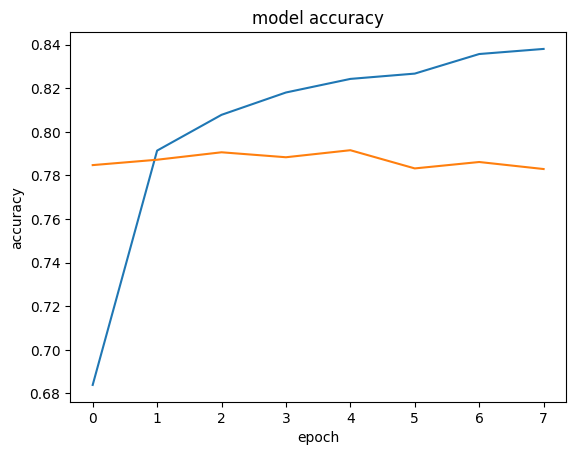

In [36]:
plot_history(history)

In [35]:
LSTM_model.evaluate(test_data_v, test_labels_v)

330/330 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.7843 - loss: 0.5656


[0.5548939108848572, 0.7883447408676147]

In [23]:
# LSTM 2 params
# vocab_size = is set above to match vectorization vocabulary
embedding_dim = 50
rnn_units = 100
dropout_rate = 0.2
batch_size = 32
epochs = 10
learning_rate = 0.01

# Build Model
LSTM2_model = build_LSTM_model(vocab_size = vocab_size, embedding_dim = embedding_dim, rnn_units = rnn_units, dropout_rate=dropout_rate, learning_rate= learning_rate)
print(LSTM2_model.summary())

# adding early stopping
callbacks = [keras.callbacks.ModelCheckpoint("LSTM2_model.keras", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
             ]

#fitting the LSTM model
history2 = LSTM2_model.fit(train_data_v,
                         train_labels_v,
                         epochs=10,
                         batch_size=32,
                         validation_data=(val_data_v,val_labels_v),
                         callbacks=callbacks)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 50)       │         50,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 100)            │         60,400 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 100)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            404 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 110,804 (432.83 KB)

 Trainable params: 110,804 (432.83 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 419s 421ms/step - accuracy: 0.5981 - loss: 0.9220 - val_accuracy: 0.7702 - val_loss: 0.5709
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 442s 421ms/step - accuracy: 0.7700 - loss: 0.5647 - val_accuracy: 0.7869 - val_loss: 0.5207
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 443s 423ms/step - accuracy: 0.7921 - loss: 0.5070 - val_accuracy: 0.7814 - val_loss: 0.5409
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 430s 435ms/step - accuracy: 0.7987 - loss: 0.4877 - val_accuracy: 0.7865 - val_loss: 0.5301
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 437s 430ms/step - accuracy: 0.8078 - loss: 0.4670 - val_accuracy: 0.7854 - val_loss: 0.5313


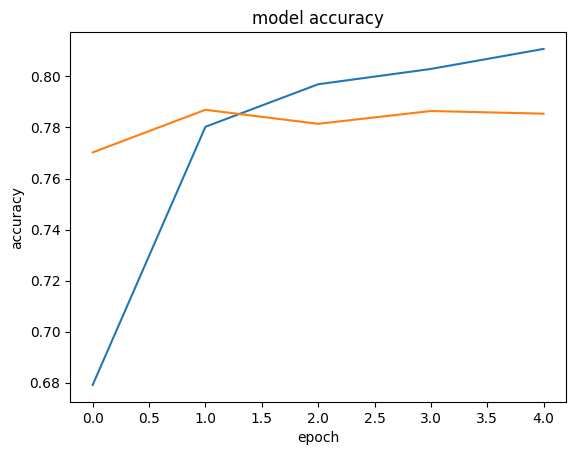

In [24]:
plot_history(history2)